In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass

In [2]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import pandas as pd
import numpy as np
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# Function to pad an array to a specific shape
def to_shape(a, shape):
    # Unpack the target shape
    y_, x_ = shape

    # Get the current shape of the array
    y, x = a.shape

    # Calculate the padding needed in the y and x directions
    y_pad = y_ - y
    x_pad = x_ - x
    output = np.zeros()
    # Pad the array using numpy's pad function
    return np.pad(
        a,
        [(0, 1), (0, 1)],
        # Calculate the padding for each dimension
        # ((y_pad // 2, y_pad // 2 + y_pad % 2), (x_pad // 2, x_pad // 2 + x_pad % 2)),
        mode="constant",
    )

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    angle = (ang1 - ang2) % (2 * np.pi)
    if angle > np.pi: angle = angle - 2*np.pi
    return angle



# Function to pad data and labels to a specific shape
def apply_padding(data_df, N, T_max):
    # Define the final shape of the data and labels
    final_shape = (N, T_max-1, 6)

    # Initialize the final data and labels with zeros
    final_data = np.zeros(final_shape)
    final_label = np.zeros((N, T_max-1, 3))

    # Select a random subset of trajectory indices
    if len(data_df["traj_idx"].unique()) < N:
        selected_ids = np.random.choice(
            data_df["traj_idx"].unique(), size=N, replace=True
        )
    else:
        selected_ids = np.random.choice(
            data_df["traj_idx"].unique(), size=N, replace=False
        )

    # Iterate over the selected trajectory indices
    for n, id in enumerate(selected_ids):
        # Filter the data for the current trajectory index
        exp = data_df[data_df["traj_idx"] == id]

        # Extract the data and labels for the current trajectory
        data = exp[["frame", "x", "y"]].to_numpy()  
        data[:, 0] = data[:, 0] - data[0, 0] + 1  # putting first frame rate to 1
        data[:, 1] = data[:, 1] - data[0, 1]  # putting initial position to 0
        data[:, 2] = (
            data[:, 2] - data[0, 2]
        )  # putting initital position to 0        # print(exp["frame"])
        # Displacement
        Dx = data[1:,1] - data[:-1,1]
        Dy = data[1:,2] - data[:-1,2]

        Dx2 = data[2:,1] - data[:-2,1]
        Dy2 = data[2:,1] - data[:-2,1]

        dist_1 = np.sqrt(Dx**2 + Dy**2)
        dist_2 = np.sqrt(Dx2**2 + Dy2**2)
        
        
        MDx = np.zeros(len(Dx))
        MDy = np.zeros(len(Dx))
        MSD = np.zeros(len(Dx))
        mean_dist_1 = np.zeros(len(Dx))
        mean_dist_2 = np.zeros(len(Dx))
        
        angles = np.zeros(len(Dx))
        distance_displacement = np.sqrt(np.power(Dx,2) + np.power(Dy,2))
        #Displacement average

        for i in range(1, len(Dx)+1):
            # MDx[i-1] = np.mean(data[i:,1] - data[:-i,1])
            # MDy[i-1] = np.mean(data[i:,2] - data[:-i,2])
            MSD[i-1] = np.mean((data[i:,2] - data[:-i,2])**2)
            A = (data[(i-1),1], data[(i-1),2])
            B = (data[i,1], data[i,2])
        
            # Computation of angles

            angles[i-1] = angle_between(A,B)

            start= i - 1
            start = max(start, 0)
            end_1 = i + 1 
            end_2 = i + 1
            if end_1 > len(Dx):
                end_1 = len(Dx)
            if end_2 >len(Dx) - 1:
                emd_2 = len(Dx) - 1

            mean_dist_1[i-1] = np.mean(mean_dist_1[start:end_1+1])
            mean_dist_2[i-1] = np.mean(mean_dist_2[start:end_2+1])
            
        label = exp[["alpha", "D", "state"]].to_numpy()
        ## adding one to the states
        label[:, 2] = label[:, 2] + 1
        # If the data is longer than T_max, truncate it
        if data.shape[0] > T_max:
            # final_data[n, :, :] = data[:T_max, :]
            final_data[n,:,0] = Dx[:(T_max-1)]
            final_data[n,:,1] = Dy[:(T_max-1)]
            final_data[n,:,2] = mean_dist_1[:(T_max-1)]
            final_data[n,:,3] = mean_dist_2[:(T_max-1)]
            final_data[n,:,4] = distance_displacement[:(T_max-1)]
            final_data[n,:,5] = angles[:(T_max-1)]

            final_label[n, :, :] = label[:T_max-1, :]

        # Otherwise, pad the data to T_max
        else:
            # print((label.shape, T_max))
            final_data[n, : (data.shape[0] -1), 0] = Dx
            final_data[n, : (data.shape[0] -1), 1] = Dy
            final_data[n, : (data.shape[0] -1), 2] = mean_dist_1
            final_data[n, : (data.shape[0] -1), 3] = mean_dist_2
            final_data[n, : (data.shape[0] -1), 4] = distance_displacement
            final_data[n, : (data.shape[0] -1), 5] = angles

            final_label[n, : data.shape[0] -1, :] = label[:-1, :]

    # Return the padded data and label
    return final_data, final_label


# Define a function to normalize data
def normalize_df(data):
    # Calculate displacement in x and y directions
    # Normalize by substring mean and dividing by variance.

    displacement_x = []
    displacement_y = []
    for _, group in data.groupby("traj_idx"):
        x = np.asarray(group["x"])
        y = np.asarray(group["y"])
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data
    data.loc[:, "x"] = (data["x"] - data["x"].mean()) / variance_x
    data.loc[:, "y"] = (data["y"] - data["y"].mean()) / variance_y


def normalize_np(data):

    displacement_x = []
    displacement_y = []
    for n in range(data.shape[0]):
        x = data[n, :, 1]
        y = data[n, :, 2]
        d_x = x[1:] - x[:-1]
        d_y = y[1:] - y[:-1]
        displacement_x = displacement_x + list(d_x)
        displacement_y = displacement_y + list(d_y)

    # Calculate variance in x and y directions
    variance_x = np.sqrt(np.std(displacement_x))
    variance_y = np.sqrt(np.std(displacement_y))

    # Normalize data

    data[:, :, 1] = (data[:, :, 1] - np.mean(data[:, :, 1])) / variance_x
    data[:, :, 2] = (data[:, :, 2] - np.mean(data[:, :, 2])) / variance_x

    return data


# Define a function to list directory tree with pathlib
def list_directory_tree_with_pathlib(starting_directory):
    path_object = Path(starting_directory)
    folders = []
    for file_path in path_object.rglob("*.csv"):
        folders.append(file_path)
    return folders


# Define a custom dataset class for all data
@dataclass
class Dataset_all_data(Dataset):
    # Initialize filenames and transform flag
    # Pad value should be a tuple such as (N, Tmax)
    filenames: list
    transform: bool = False
    pad: None | tuple = None
    noise: bool = False

    def __len__(self):
        # Return the number of files
        return len(self.filenames)

    def __getitem__(self, idx):
        # Read csv file and extract data and label
        df = pd.read_csv(self.filenames[idx])

        if self.pad is None:
            data = df[["traj_idx", "frame", "x", "y"]]
            label = np.asarray(df[["alpha", "D"]])
            label_2 = np.asarray(df["state"])

        else:
            if len(self.pad) != 2:
                raise ValueError("pad value should be set as (N, T_max)")
            data, label = apply_padding(df, *self.pad)
            data = data[:, :, :]  ## Removing the frame column
            label_2 = label[:, :, -1]
            label_2[label_2[:, :] > 0] = label_2[label_2[:, :] > 0]
            label = label[:, :, :-1]

        # Normalize data if transform flag is True
        if self.transform:
            if self.pad is None:
                normalize_df(data)
                data = np.asarray(data)
            else:
                data = normalize_np(data)

        if self.noise:
            data = add_noise(data)

        # Normalize D between 0 and 1

        # label[:,:,1][label[:,:,1] != 0] = np.log(label[:,:,1][label[:,:,1] != 0]) #- np.log(1e-6)) #/   (np.log(1e12) - np.log(1e-6))
        # label = label[:,:,1]
        label_K = np.zeros((label.shape[0], 2))

        # print(np.unique(label_2))

        for i in range(label.shape[0]):
            K = np.unique(label[i, :, 1][label[i, :, 1] != 0])
            if len(K) == 2:
                label_K[i, :] = K

                if label[i, 0, 1] != label_K[i, 0]:
                    label_K[i, :] = label_K[i, ::-1]

            elif len(K) == 1:
                states = label_2[i, :]
                if 1 in states:
                    # print(np.unique(states))
                    if states[0] == 1:
                        label_K[i, :] = [0, K[0]]
                    else:
                        label_K[i, :] = [K[0], 0]

                    # print(label_regression[i,:])

                else:
                    label_K[i, :] = [K[0], K[0]]

            else:
                if np.unique(label[i, :, 1]) == 0:
                    label_K[i, :] = [0, 0]
                else:

                    # print(np.unique(label[i,:,1]))

                    # print(Ds)
                    raise Exception("more than 2 diffusions")

        # print(np.unique(label_2))
        label_alpha = np.zeros((label.shape[0], 2))

        for i in range(label.shape[0]):
            alpha = np.unique(label[i, :, 0][label[i, :, 0] != 0])
            if len(alpha) == 2:
                label_alpha[i, :] = alpha
                if label[i, 0, 0] != label_alpha[i, 0]:
                    label_alpha[i, :] = label_alpha[i, ::-1]

            elif len(alpha) == 1:
                states = label_2[i, :]
                if 1 in states:
                    # print(np.unique(states))
                    if states[0] == 1:
                        label_alpha[i, :] = [0, alpha[0]]
                    else:
                        label_alpha[i, :] = [alpha[0], 0]

                    # print(label_regression[i,:])

                else:
                    label_alpha[i, :] = [alpha[0], alpha[0]]

            else:
                if np.unique(label[i, :, 1]) == 0:
                    label_alpha[i, :] = [0, 0]
                else:

                    # print(np.unique(label[i,:,1]))

                    # print(Ds)
                    raise Exception("more than 2 diffusions")

        label_segmentation = np.zeros((label_2.shape[0], label_2.shape[1]))

        for i in range(label.shape[0]):
            if label_K[i, 0] == label_K[i, 1]:
                position = label[i, :, 1] == label_K[i, 0]
                label_segmentation[i, position] = 1
            else:

                position_1 = label[i, :, 1] == label_K[i, 0]
                position_2 = label[i, :, 1] == label_K[i, 1]

                label_segmentation[i, position_1] = 1
                label_segmentation[i, position_2] = 2

        return (
            torch.from_numpy(data.astype(np.float32)),
            torch.from_numpy(label_segmentation.astype(np.float32)),
            torch.from_numpy(label_K),
            torch.from_numpy(label_alpha),
        )
        # torch.from_numpy(label_2.astype(np.float32)),


def add_noise(data):
    noise_amplitude = np.random.choice(
        [
            0,
            0.01,
            0.1,
        ]
    )
    noise = np.random.normal(0, noise_amplitude, data[:, :, :].shape)
    data[:, :, :][data[:, :, 1:] != 0] = (
        data[:, :, :][data[:, :, 1:] != 0] + data[:, :, :][data[:, :, 1:] != 0] * noise
    )
    return data

In [3]:
all_data_set = list_directory_tree_with_pathlib(
    r"../data/",
)
np.random.shuffle(all_data_set)

In [4]:
len(all_data_set)

159609

In [5]:
training_dataset = Dataset_all_data(all_data_set[:100000], transform=False, pad=(20, 200))

In [6]:
test = iter(training_dataset)

In [7]:
a = next(test)

In [8]:
# a

In [9]:
dataloader = DataLoader(training_dataset, shuffle=True, batch_size=20, num_workers=10)

In [10]:
from einops import rearrange

In [11]:
from mamba_ssm import  Mamba

/home/brownianxgames/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class segmentation_model(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.2, device="cuda"):
        super().__init__()
        self.device = device

        self.lstm = nn.LSTM(
            input_size = d_model,
            hidden_size=d_state,
            num_layers = expand,
            bidirectional=True,
            batch_first=True,
            ).to(device)
        
        self.dropout = nn.Dropout(p=dropout).to(device)
        self.dense = nn.Linear(d_state * 2, 3).to(device)

    def forward(self, x):
        

        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        dense_out = self.dense(lstm_out)
        return dense_out  # No activation here ! It is done by the cross entropy loss


class K_regression(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        ).to(device)
        self.flipped_mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        ).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features=199 * d_model*2, out_features=2).to(device)

        self.softplus = nn.Softplus()

    def forward(self, input):

        forward_mamba = self.mamba(input)
        backward_mamba = self.flipped_mamba(torch.flip(input, dims=[1]))
        backward_mamba = torch.flip(backward_mamba, dims=[1])
        
        mamba_out = torch.cat((forward_mamba, backward_mamba), dim=-1)

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")

        mamba_out = self.dropout(mamba_out)
        out = self.fc(mamba_out)
        out = torch.clamp(out, min=0, max=1e12)
        out[out < 1e-7] = 0
        return out


class alpha_regression(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.3, device="cuda"):
        super().__init__()
        self.device = device

        self.mamba = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        ).to(device)
        self.flipped_mamba = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        ).to(device)

        self.dropout = nn.Dropout(p=dropout).to(device)
        self.fc = nn.Linear(in_features=199 * d_model * 2, out_features=2).to(device)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):

        forward_mamba = self.mamba(input)
        backward_mamba = self.flipped_mamba(torch.flip(input, dims=[1]))
        backward_mamba = torch.flip(backward_mamba, dims=[1])
        
        mamba_out = torch.cat((forward_mamba, backward_mamba), dim=-1)

        mamba_out = rearrange(mamba_out, "b l c -> b (l c)")

        mamba_out = self.dropout(mamba_out)
        out = self.fc(mamba_out)
        
        return self.sigmoid(out) * 2 

In [13]:
class all_at_the_same_time(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand, dropout=0.2, device="cuda"):
        super().__init__()
        self.device = device

        self.model_K = K_regression(
            d_model+1, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )
        self.model_alpha = alpha_regression(
            d_model+1, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )
        self.segmentation = segmentation_model(
            d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout
        )

    def forward(self, x):
        probas = self.segmentation(x)

        classes = torch.argmax(torch.softmax(probas, dim=2), dim=2)

        classes[x[:, :, 0] == 0] = 0

        classes[x[:, :, 0] == 0] = 0
        classes = classes.unsqueeze(-1)  # adding a dimension for the next step
        concat_entry = torch.cat((classes, x[:,:,:]), dim=2)

        alpha = self.model_alpha(concat_entry)

        K = self.model_K(concat_entry)

        return probas, alpha, K

In [14]:
model = alpha_regression(d_model=6, d_state=128, d_conv=4, expand=4, dropout=0.1)

In [15]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
alpha_criterion = torch.nn.L1Loss().to("cuda")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return self.mse(torch.log(pred + 1), torch.log(actual + 1))


K_criterion = MSLELoss().to("cuda")

In [16]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

max_epoch = 10
# total_classification_loss = []
total_K_loss = []
total_alpha_loss = []

for epoch in range(max_epoch):
    running_classification_loss = []
    running_alpha_loss = []
    running_K_loss = []

    with tqdm(dataloader, unit="batch") as tepoch:
        model.train()

        for inputs, classification_targets, K_targets, alpha_targets in tepoch:

            tepoch.set_description(f"Epoch {epoch}")

            inputs = inputs.to("cuda", dtype=torch.float32)  # Ensuring float32 type
            inputs = torch.flatten(inputs, start_dim=0, end_dim=1)

            classification_targets = (
                torch.flatten(
                    classification_targets,
                    start_dim=0,
                    end_dim=1,
                )
                .type(torch.LongTensor)
                .to("cuda")
            )

            optimizer.zero_grad()

            alpha_output = model(inputs[:,:,:])
            # classification_output = torch.squeeze(K_output)

            alpha_targets = torch.flatten(alpha_targets, start_dim=0, end_dim=1).to(
                "cuda", dtype=torch.float32
            )  # Ensuring float32 type
            alpha_loss = alpha_criterion(alpha_output, alpha_targets).to(
                "cuda", dtype=torch.float32
            )  # Ensuring float32 type   
            

            total_loss = alpha_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            tepoch.set_postfix(
                # loss_c=classification_loss.item(),
                loss_a=alpha_loss.item(),
                # loss_K=K_loss.item(),
            )

            # running_classification_loss.append(classification_loss.item())
            running_alpha_loss.append(
                alpha_loss.item()
            )  # Corrected to alpha_loss.item()
            # running_K_loss.append(K_loss.item())  # Corrected to K_loss.item()
        
        scheduler.step()
        # total_classification_loss.append(np.mean(running_classification_loss))
        total_alpha_loss.append(np.mean(running_alpha_loss))
        # total_K_loss.append(np.mean(running_K_loss))

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [16:12<00:00,  5.14batch/s, loss_a=0.118]


In [17]:
stop

NameError: name 'stop' is not defined

In [ ]:
alpha_targets.size()

In [ ]:
total_classification_loss[-10:]

In [21]:
torch.save(model, "10_epoch_bimamba_100kfiles_alpha")

In [ ]:
# total_classification_loss

In [19]:
import matplotlib.pyplot as plt

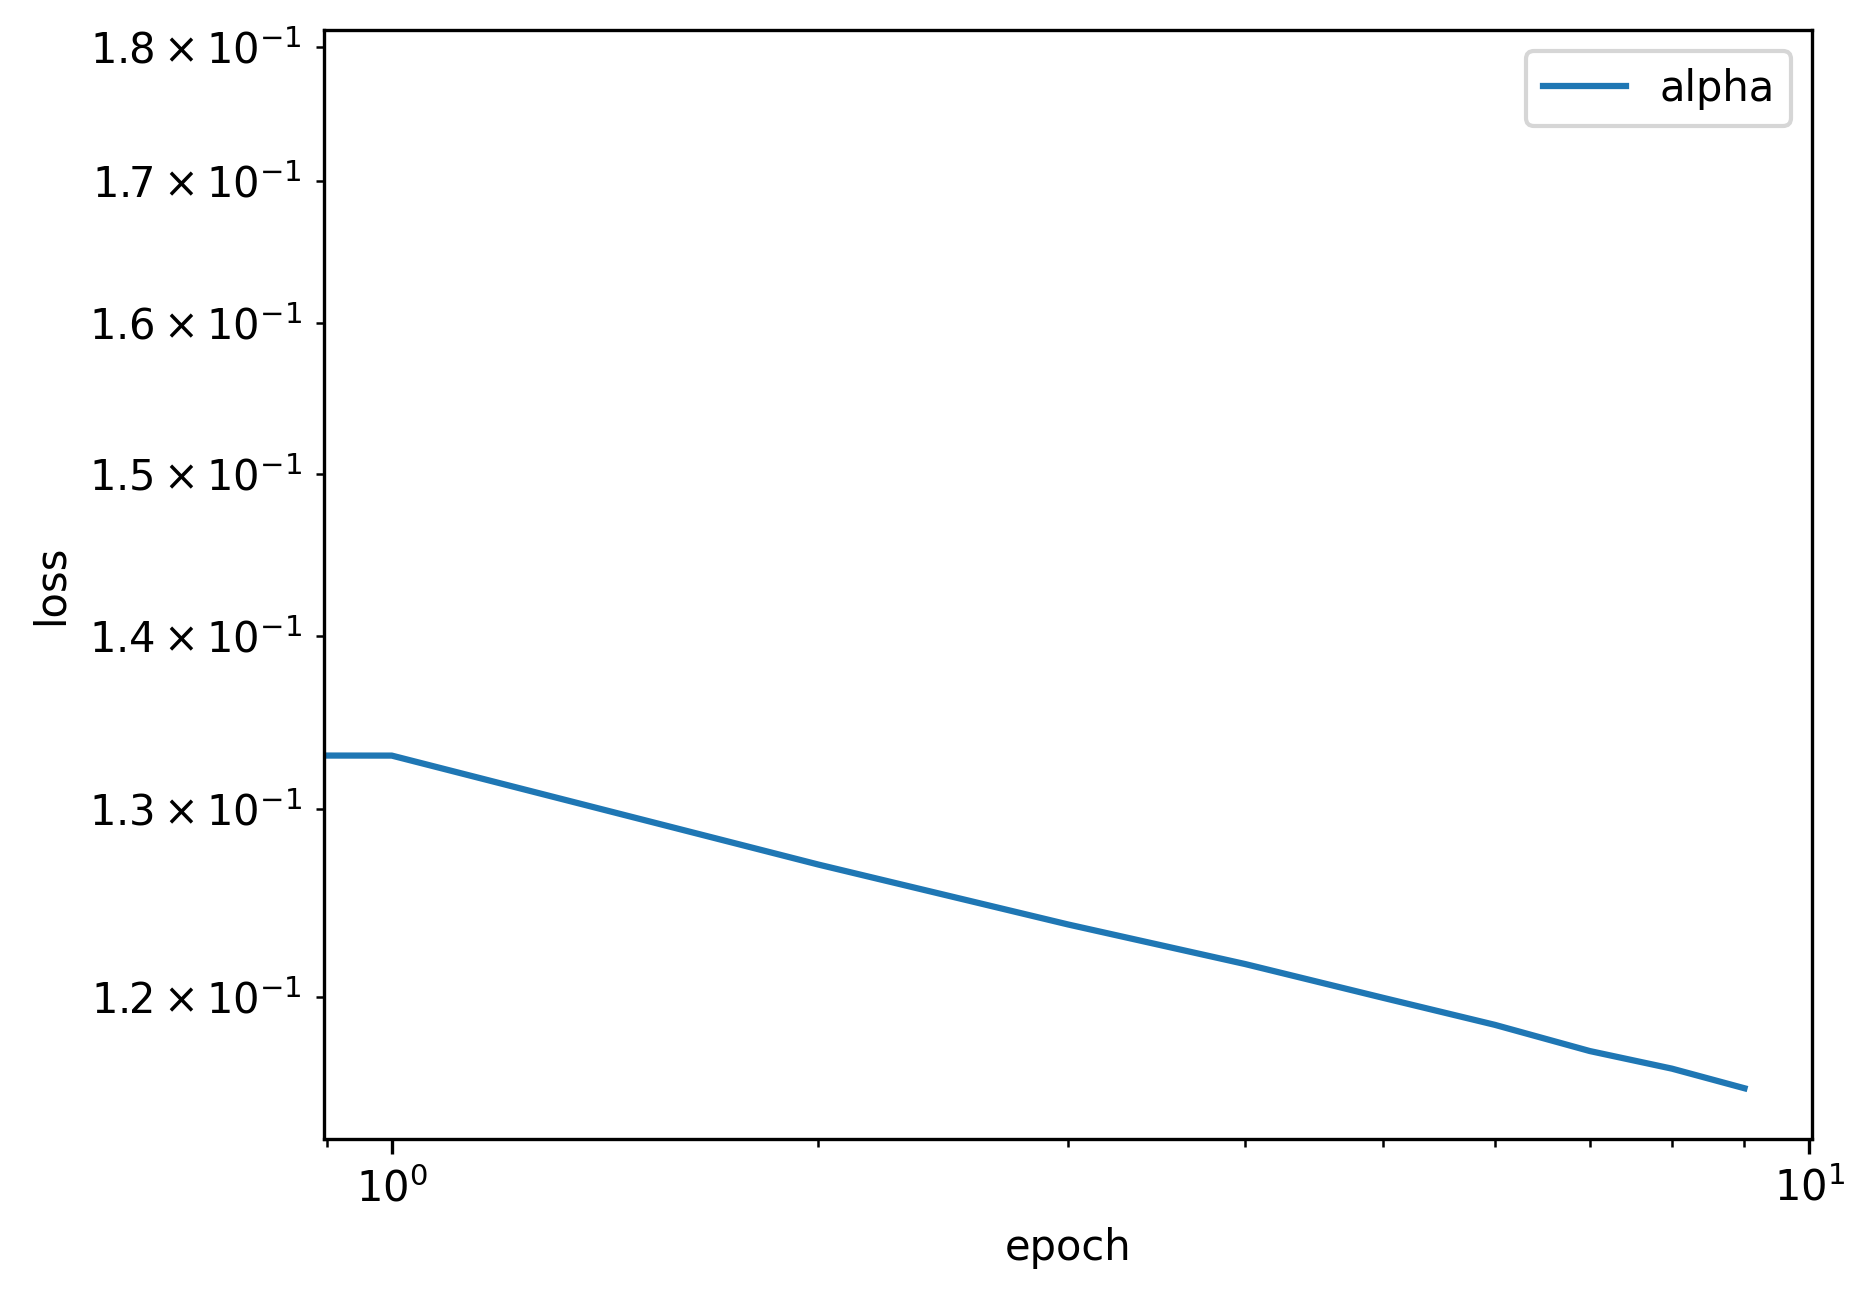

In [20]:
plt.figure(dpi = 300)
plt.loglog(total_alpha_loss, label = "alpha")
#plt.loglog(total_classification_loss, label="classification")
# plt.loglog(total_K_loss, label = "k")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
# plt.savefig("1000epoch18kfiles.pdf")

In [ ]:
# torch.save(model, "all_at_sam_time_simple_1000epoch_18kfiles")